In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyod.models.lof import LOF
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('whitegrid')

In [4]:
DATA_DIR = 'C:/Users/user/OneDrive/Desktop/finance-data'

In [5]:
transaction_df = pd.read_csv(DATA_DIR+'/PS_20174392719_1491204439457_log.csv')

In [6]:
transaction_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [7]:
transaction_df[transaction_df['type'] == 'PAYMENT'].isFraud.sum()

0

In [8]:
transaction_df[transaction_df['type'] == 'TRANSFER'].isFraud.sum()

4097

In [9]:
# for type_ in transaction_df.type.unique():
#     print(f"{type_} -> {transaction_df[transaction_df['type'] == type_].isFraud.sum()}")

transaction_df.groupby('type')['isFraud'].sum()

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

In [10]:
transaction_df[transaction_df['type'] == 'TRANSFER']

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0


In [11]:
transaction_df = transaction_df[transaction_df['type'].isin(['TRANSFER', 'CASH_OUT'])].reset_index().drop(columns=['index'])

In [12]:
transaction_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
2,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
3,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
4,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2770404,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
2770405,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
2770406,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
2770407,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [13]:
from scipy.stats import zscore

In [14]:
# helper function

def zscore(series):
    mean_s = series.mean()
    std_s = series.std()
    
    zscore_list = []
    for x in series:
        zscore_list.append((x - mean_s) / std_s)
    return zscore_list

def Zscore_outlier(df):
    out=[]
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(i)
    return out

def plot_distributions(data, color='blue'):
    """
    This function takes a pandas DataFrame as input and plots the distribution of each feature
    in a single figure. The number of rows and columns in the figure is determined dynamically
    based on the number of features in the DataFrame. The "darkgrid" theme from seaborn is applied
    to the plots. You can specify a color for the bars in the histogram by passing a "color" parameter.
    """
    sns.set_theme(style='whitegrid')  # set the seaborn theme

    num_cols = 3  # set the number of columns per row
    num_features = len(data.columns)
    num_rows = math.ceil(num_features / num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))

    for i, column in enumerate(data.columns):
        row = i // num_cols
        col = i % num_cols
        axs[row][col].hist(data[column], bins=30, alpha=0.5, color=color)
        axs[row][col].set_title(f'Distribution of {column}')
        axs[row][col].set_xlabel(column)
        axs[row][col].set_ylabel('Frequency')
    
    fig.tight_layout(pad=2.0)
    plt.show()

In [15]:
transaction_df['amount_zscore'] = zscore(transaction_df['amount'])

In [16]:
transaction_df[transaction_df['amount_zscore'] > 3]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_zscore
360,1,TRANSFER,3776389.09,C197491520,0.00,0.00,C1883840933,10138670.86,16874643.09,0,0,3.896028
953,4,TRANSFER,10000000.00,C7162498,12930418.44,2930418.44,C945327594,0.00,0.00,1,0,10.906259
954,4,CASH_OUT,10000000.00,C351297720,10000000.00,0.00,C766681183,0.00,9941904.21,1,0,10.906259
2339,7,TRANSFER,5460002.91,C666654362,5460002.91,0.00,C1726301214,0.00,0.00,1,0,5.792438
2340,7,CASH_OUT,5460002.91,C1588880909,5460002.91,0.00,C1570256460,0.00,9281535.44,1,0,5.792438
...,...,...,...,...,...,...,...,...,...,...,...,...
2770373,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.00,0.00,1,1,6.034100
2770387,742,TRANSFER,4009058.39,C1044665079,4009058.39,0.00,C750074708,0.00,0.00,1,0,4.158105
2770388,742,CASH_OUT,4009058.39,C1970706589,4009058.39,0.00,C637394241,1229761.96,5238820.34,1,0,4.158105
2770405,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,6.751456


In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
le = LabelEncoder()

In [19]:
transaction_df['type'] = le.fit_transform(transaction_df['type'])

In [20]:
le.inverse_transform(transaction_df['type'])

array(['TRANSFER', 'CASH_OUT', 'CASH_OUT', ..., 'CASH_OUT', 'TRANSFER',
       'CASH_OUT'], dtype=object)

In [21]:
le.classes_

array(['CASH_OUT', 'TRANSFER'], dtype=object)

In [22]:
transaction_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_zscore
0,1,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,-0.357467
1,1,0,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,-0.357467
2,1,0,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0,-0.099576
3,1,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,-0.115146
4,1,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,-0.006590
...,...,...,...,...,...,...,...,...,...,...,...,...
2770404,743,0,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,0.024945
2770405,743,1,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,6.751456
2770406,743,0,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,6.751456
2770407,743,1,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,0.599766


In [326]:
transaction_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'amount_zscore'],
      dtype='object')

In [ ]:
# plot_distributions(transaction_df)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000021F2413AB90> (for post_execute):


KeyboardInterrupt: 

# Overview of the data in 2 dimensions

In [280]:
# sample data

inliers = transaction_df[transaction_df['isFraud'] == 0].sample(10000)
outliers = transaction_df[transaction_df['isFraud'] == 1].sample(500)

concat_df = pd.concat([inliers, outliers])

X = concat_df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = concat_df[['isFraud']]

In [281]:
# PCA (Linear)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sample_pca = pd.DataFrame(X_2d)
sample_pca['isFraud'] = y['isFraud'].tolist()


# TSNE (Non Linear)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
sample_tsne = pd.DataFrame(X_tsne)
sample_tsne['isFraud'] = y['isFraud'].tolist()

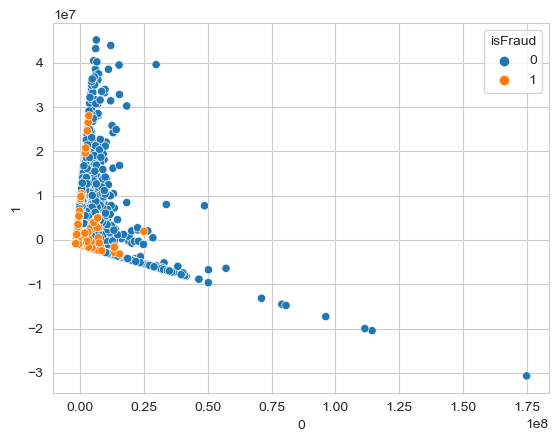

In [282]:
sns.scatterplot(x=sample_pca.iloc[:,0], y=sample_pca.iloc[:,1], hue=sample_pca.iloc[:,2]);

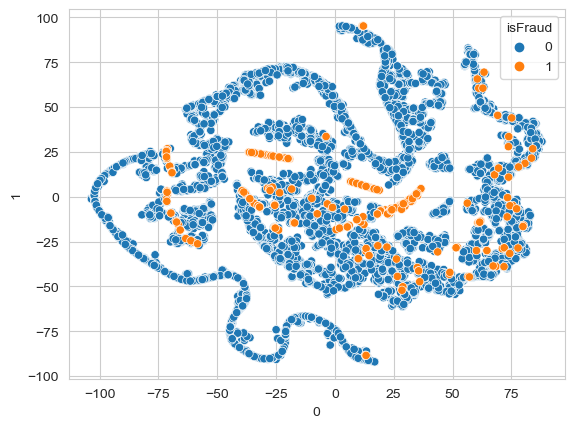

In [283]:
sns.scatterplot(x=sample.iloc[:,0], y=sample.iloc[:,1], hue=sample.iloc[:,2]);

# Model Development

### Local Outlier Factor (sklearn)

In [24]:
indep_var = [
    "step",
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",  
]

dep_var = 'isFraud'

In [25]:
X = transaction_df[indep_var]
y = transaction_df[dep_var]

In [26]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,181.00,181.00,0.0,0.00,0.00
1,1,181.00,181.00,0.0,21182.00,0.00
2,1,229133.94,15325.00,0.0,5083.00,51513.44
3,1,215310.30,705.00,0.0,22425.00,0.00
4,1,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...
2770404,743,339682.13,339682.13,0.0,0.00,339682.13
2770405,743,6311409.28,6311409.28,0.0,0.00,0.00
2770406,743,6311409.28,6311409.28,0.0,68488.84,6379898.11
2770407,743,850002.52,850002.52,0.0,0.00,0.00


In [28]:
sc = StandardScaler()

In [29]:
X_scale = sc.fit_transform(X)

In [31]:
X_scale.shape

(2770409, 6)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=21, stratify=y)

In [ ]:
lof_obj = LocalOutlierFactor(n_neighbors=15,contamination=0.1, novelty=True)
lof_obj.fit(X_train)
y_pred = lof_obj.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [ ]:
np.unique(y_pred, return_counts=True)

In [ ]:
print(classification_report(y_test,y_pred))

### Local Outlier Factor (pyod)

In [314]:
lof_pyod = LOF()

In [315]:
lof_pyod.fit(X_train)

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)

In [316]:
y_pred_pyod = lof_pyod.predict(X_test)

In [318]:
print(classification_report(y_test,y_pred_pyod))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94    828659
           1       0.00      0.14      0.01      2464

    accuracy                           0.89    831123
   macro avg       0.50      0.52      0.48    831123
weighted avg       0.99      0.89      0.94    831123



### Local Outlier Factor (PyCaret)

In [320]:
#pip install pycaret

In [48]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,181.00,181.00,0.0,0.00,0.00
1,1,181.00,181.00,0.0,21182.00,0.00
2,1,229133.94,15325.00,0.0,5083.00,51513.44
3,1,215310.30,705.00,0.0,22425.00,0.00
4,1,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...
2770404,743,339682.13,339682.13,0.0,0.00,339682.13
2770405,743,6311409.28,6311409.28,0.0,0.00,0.00
2770406,743,6311409.28,6311409.28,0.0,68488.84,6379898.11
2770407,743,850002.52,850002.52,0.0,0.00,0.00


In [32]:
from pycaret.anomaly import *

exp_ano101 = setup(X, normalize = True, 
                   session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(2770409, 6)"
2,Transformed data shape,"(2770409, 6)"
3,Numeric features,6
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


In [34]:
lof_pycaret = create_model('lof')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
lof_results = assign_model(lof_pycaret)
lof_results.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,Anomaly,Anomaly_Score
0,1,181.000000,181.0,0.0,0.0,0.000000e+00,0,1.059477
1,1,181.000000,181.0,0.0,21182.0,0.000000e+00,0,1.024568
2,1,229133.937500,15325.0,0.0,5083.0,5.151344e+04,1,1.994811
3,1,215310.296875,705.0,0.0,22425.0,0.000000e+00,1,2.311887
4,1,311685.875000,10835.0,0.0,6267.0,2.719173e+06,0,1.150251


In [40]:
transaction_df['lof_pred_pycaret'] = lof_results['Anomaly']

In [43]:
transaction_df[(transaction_df['isFraud'] == 1) & (transaction_df['lof_pred_pycaret'] == 1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_zscore,lof_pred_pycaret
346,1,1,35063.63,C1364127192,35063.63,0.0,C1136419747,0.00,0.00,1,0,-0.318175,1
347,1,0,35063.63,C1635772897,35063.63,0.0,C1983025922,31140.00,7550.03,1,0,-0.318175,1
551,1,0,132842.64,C13692003,4499.08,0.0,C297927961,0.00,132842.64,1,0,-0.208037,1
603,1,1,235238.66,C1872047468,235238.66,0.0,C116289363,0.00,0.00,1,0,-0.092699,1
604,1,0,235238.66,C1499825229,235238.66,0.0,C2100440237,0.00,235238.66,1,0,-0.092699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770393,742,1,54652.46,C1674778854,54652.46,0.0,C1930074465,0.00,0.00,1,0,-0.296110,1
2770394,742,0,54652.46,C43545501,54652.46,0.0,C830041824,0.00,54652.46,1,0,-0.296110,1
2770399,742,1,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0,-0.286238,1
2770400,742,0,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0,-0.286238,1


In [46]:
transaction_df[transaction_df['lof_pred_pycaret'] == 1].shape

(138521, 13)

In [47]:
transaction_df[transaction_df['isFraud'] == 1].shape

(8213, 13)

# supervised approach

In [5]:
transaction_df = pd.read_csv(DATA_DIR+'/PS_20174392719_1491204439457_log.csv')
transaction_df = transaction_df[transaction_df['type'].isin(['TRANSFER', 'CASH_OUT'])].reset_index().drop(columns=['index'])

indep_var = [
    "step",
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",  
]

dep_var = 'isFraud'


X = transaction_df[indep_var]
y = transaction_df[dep_var]

In [6]:


ros = SMOTE()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_resample, y_resample = ros.fit_resample(X_train, y_train)

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf = RandomForestClassifier(n_estimators=30)

In [20]:
rf.fit(X_resample, y_resample)

RandomForestClassifier(n_estimators=30)

In [21]:
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828689
           1       0.67      0.93      0.78      2434

    accuracy                           1.00    831123
   macro avg       0.84      0.96      0.89    831123
weighted avg       1.00      1.00      1.00    831123



In [23]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1933507
           1       1.00      1.00      1.00      5779

    accuracy                           1.00   1939286
   macro avg       1.00      1.00      1.00   1939286
weighted avg       1.00      1.00      1.00   1939286



# Backlog

In [ ]:
# def run_model(X, y, model):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)
#     lof_obj = model(n_neighbors=15,contamination=0.1, novelty=True)
#     lof_obj.fit(X_train)
#     y_pred = lof_obj.predict(X_test)
#     y_pred[y_pred == 1] = 0
#     y_pred[y_pred == -1] = 1